# Sufficient Statistic Bias Calculations Normal 1 parameter known variance

In [4]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

## Hypothesis

### Hypothesis Bias Against

In [6]:
import numpy as np
from scipy.stats import norm

def ss_hypothesis_bias_against_normal_1p(
    n_sample,
    hypothesis,
    n_datasets=1000,
    n_marginal=1000,
    sigma=1,
    prior_mu=0,
    prior_sigma=1,
    cumulative=False
):
    """
    Calculate the bias against a hypothesis using the sufficient statistic approach.

    Parameters:
    - n_sample (int): Sample size for each dataset.
    - hypothesis (float): The hypothesized value of theta.
    - n_datasets (int): Number of datasets to simulate.
    - n_marginal (int): Number of samples to estimate the marginal likelihood.
    - sigma (float): Known standard deviation of the data.
    - prior_mu (float): Mean of the prior distribution.
    - prior_sigma (float): Standard deviation of the prior distribution.
    - cumulative (bool): Whether to return cumulative bias against values.

    Returns:
    - float or np.ndarray: Final bias against estimate or cumulative bias against values.
    """

    # Step 1: Generate sample means x̄ from the sampling distribution under the hypothesis
    se = sigma / np.sqrt(n_sample)  # Standard error of the mean
    x_bar = np.random.normal(hypothesis, se, size=n_datasets)

    # Step 2: Compute the log-likelihood of x̄ under the hypothesis
    log_likelihood = norm.logpdf(x_bar, loc=hypothesis, scale=se)

    # Step 3: Sample theta from the prior distribution
    theta_samples = np.random.normal(prior_mu, prior_sigma, size=n_marginal)

    # Step 4: Compute the marginal likelihood p(x̄) via Monte Carlo integration
    # Compute p(x̄ | theta) for each theta_sample and x̄
    # Shape of likelihoods: (n_datasets, n_marginal)
    likelihoods = norm.pdf(
        x_bar[:, np.newaxis],
        loc=theta_samples[np.newaxis, :],
        scale=se
    )

    # Estimate p(x̄) for each x̄
    p_x_bar = np.mean(likelihoods, axis=1)

    # Compute log marginal likelihood
    log_marginal_likelihood = np.log(p_x_bar)

    # Step 5: Compute the bias against
    bias_against = (log_likelihood - log_marginal_likelihood) <= 0

    # Compute cumulative bias against if requested
    bias_against_cumsum = np.cumsum(bias_against) / np.arange(1, n_datasets + 1)

    if cumulative:
        # Optionally skip initial values (e.g., burn-in period)
        return bias_against_cumsum[300:]
    else:
        return bias_against_cumsum[-1]




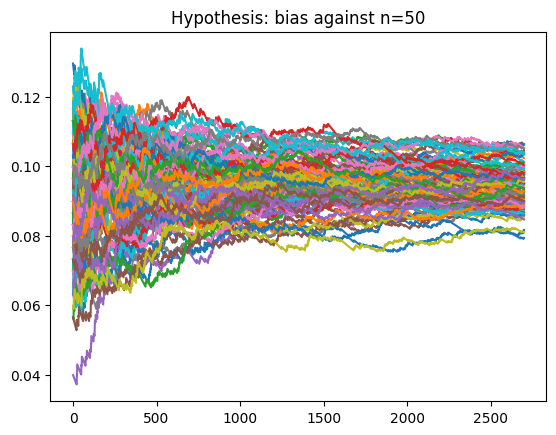

In [20]:
n = 5; n_datasets = 3000; hypothesis = 1; σ = 1

loops = 100
bias_against = [ss_hypothesis_bias_against_normal_1p(n_sample=n, hypothesis=hypothesis, n_datasets=n_datasets, sigma = σ, cumulative=True) for i in range(loops)]

for i in range(loops):
    plt.plot(bias_against[i])
    plt.title(f"Hypothesis: bias against n=50")
plt.show()

### Hypothesis Bias in Favor

In [16]:
import numpy as np
from scipy.stats import norm
from scipy.special import logsumexp

def ss_hypothesis_bias_in_favor_normal_1p(
    n_sample,
    hypothesis,
    delta,
    n_datasets=1000,
    n_marginal=1000,
    sigma=1,
    prior_mu=0,
    prior_sigma=1,
    cumulative=False
):
    """
    Estimates the bias in favor of a normal hypothesis using the sufficient statistic approach.
    
    Parameters:
    ----------
    n_sample : int
        Sample size for each dataset (number of observations).
    hypothesis : float
        The hypothesized value of theta (theta_0).
    delta : float
        The specified distance delta.
    n_datasets : int, optional
        Number of datasets (sample means) to simulate (default is 1000).
    n_marginal : int, optional
        Number of samples to estimate the marginal likelihood (default is 1000).
    sigma : float, optional
        Known standard deviation of the data (default is 1).
    prior_mu : float, optional
        Mean of the prior distribution (default is 0).
    prior_sigma : float, optional
        Standard deviation of the prior distribution (default is 1).
    cumulative : bool, optional
        If True, returns the cumulative bias in favor (default is False).
    
    Returns:
    -------
    float or np.ndarray
        Final bias in favor estimate or cumulative bias in favor values.
    """
    # Standard error of the mean
    se = sigma / np.sqrt(n_sample)
    
    # Initialize to store results for +delta and -delta cases
    bias_in_favor_cumsums = []
    
    # Loop over +delta and -delta shifts
    for shift in [+delta, -delta]:
        # Step 1: Set theta = hypothesis + delta or hypothesis - delta
        theta = hypothesis + shift
        
        # Step 2: Generate sample means x̄ from p(x̄ | theta)
        x_bar = np.random.normal(theta, se, size=n_datasets)
        
        # Step 3: Compute log-likelihoods of x̄ under the hypothesis
        log_likelihood = norm.logpdf(x_bar, loc=hypothesis, scale=se)
        
        # Step 4: Sample theta_j from the prior distribution
        theta_j_samples = np.random.normal(prior_mu, prior_sigma, size=n_marginal)
        
        # Step 5: Compute the marginal likelihood p(x̄) via Monte Carlo integration
        # Compute p(x̄ | theta_j) for each theta_j and x̄
        # Shape: (n_datasets, n_marginal)
        likelihoods = norm.pdf(
            x_bar[:, np.newaxis],
            loc=theta_j_samples[np.newaxis, :],
            scale=se
        )
        
        # Estimate p(x̄) for each x̄
        p_x_bar = np.mean(likelihoods, axis=1)
        
        # Compute log marginal likelihood
        log_marginal_likelihood = np.log(p_x_bar)
        
        # Step 6: Compute the log relative belief ratio for each x̄
        log_rb = log_likelihood - log_marginal_likelihood
        
        # Step 7: Determine bias in favor: RB(theta_0 | x̄) > 1
        bias_in_favor = (log_rb > 0).astype(int)
        
        # Calculate cumulative bias in favor (running mean)
        bias_in_favor_cumsum = np.cumsum(bias_in_favor) / np.arange(1, len(bias_in_favor) + 1)
        bias_in_favor_cumsums.append(bias_in_favor_cumsum)
    
    # Step 8: Compare the cumulative bias for +delta and -delta, and choose the one with higher cumulative bias
    final_bias_cumsum = max(bias_in_favor_cumsums, key=lambda x: x[-1])
    
    # Return cumulative bias if `cumulative=True`, otherwise return the final bias value
    if cumulative:
        # Optionally skip initial values (e.g., burn-in period)
        return final_bias_cumsum[300:]
    else:
        return final_bias_cumsum[-1]


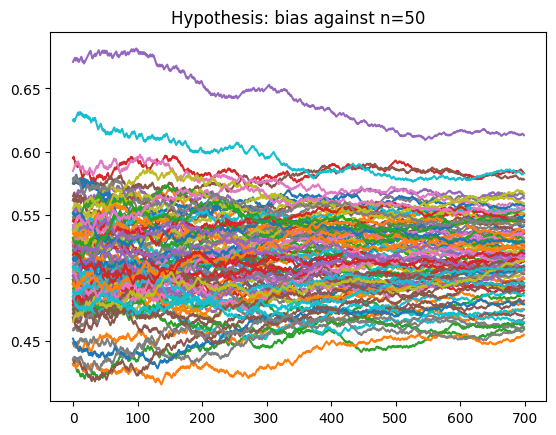

In [22]:
n = 5; n_datasets = 1000; hypothesis = 1; σ = 1; delta = 1

loops = 100
bias_in_favor = [ss_hypothesis_bias_in_favor_normal_1p(n_sample=n, delta=delta, hypothesis=hypothesis, n_datasets=n_datasets, sigma = σ, cumulative=True) for i in range(loops)]

for i in range(loops):
    plt.plot(bias_in_favor[i])
    plt.title(f"Hypothesis: bias against n=5")
plt.show()

## Estimation 

### Estimation Bias Against

In [23]:
import numpy as np
from scipy.stats import norm
from scipy.special import logsumexp

def ss_estimation_bias_against_normal_1p(
    n_sample,
    n_datasets=1000,
    n_marginal=1000,
    sigma=1,
    prior_mu=0,
    prior_sigma=1,
    cumulative=False
):
    """
    Estimates the bias against a normal parameter estimate using sufficient statistics.

    Parameters:
    ----------
    n_sample : int
        Sample size for each dataset (number of observations).
    n_datasets : int, optional
        Number of datasets (sample means) to simulate (default is 1000).
    n_marginal : int, optional
        Number of samples to estimate the marginal likelihood (default is 1000).
    sigma : float, optional
        Known standard deviation of the data (default is 1).
    prior_mu : float, optional
        Mean of the prior distribution (default is 0).
    prior_sigma : float, optional
        Standard deviation of the prior distribution (default is 1).
    cumulative : bool, optional
        If True, returns the cumulative bias against (default is False).

    Returns:
    -------
    float or np.ndarray
        Final bias against estimate or cumulative bias against values.
    """
    # Standard error of the mean
    se = sigma / np.sqrt(n_sample)
    
    # Step 1: Sample theta_0 from the prior distribution
    theta_0_samples = np.random.normal(prior_mu, prior_sigma, size=n_datasets)
    
    # Step 2: Generate sample means x̄ from p(x̄ | theta_0)
    x_bar = np.random.normal(theta_0_samples, se)
    
    # Step 3: Compute log-likelihoods of x̄ under theta_0
    log_likelihood = norm.logpdf(x_bar, loc=theta_0_samples, scale=se)
    
    # Step 4: Sample theta_j from the prior distribution
    theta_j_samples = np.random.normal(prior_mu, prior_sigma, size=n_marginal)
    
    # Step 5: Compute the marginal likelihood p(x̄) via Monte Carlo integration
    # Compute p(x̄ | theta_j) for each theta_j and x̄
    # Shape: (n_datasets, n_marginal)
    likelihoods = norm.pdf(
        x_bar[:, np.newaxis],
        loc=theta_j_samples[np.newaxis, :],
        scale=se
    )
    
    # Estimate p(x̄) for each x̄
    p_x_bar = np.mean(likelihoods, axis=1)
    
    # Compute log marginal likelihood
    log_marginal_likelihood = np.log(p_x_bar)
    
    # Step 6: Compute the bias against
    bias_against = (log_likelihood - log_marginal_likelihood) <= 0
    
    # Compute cumulative bias against if requested
    bias_against_cumsum = np.cumsum(bias_against) / np.arange(1, n_datasets + 1)
    
    if cumulative:
        # Optionally skip initial values (e.g., burn-in period)
        return bias_against_cumsum[300:]
    else:
        return bias_against_cumsum[-1]


In [26]:
# Example parameters
mu_0 = 0.0         # Prior mean
sigma_0 = 1.0        # Prior standard deviation
sigma = 1.0        # Known standard deviation
n = 50             # Sample size
n_datasets = 1000      # Number of iterations

np.mean([ss_estimation_bias_against_normal_1p(n_sample=n, n_datasets=n_datasets, sigma = sigma,prior_sigma= sigma_0, cumulative=False) for _ in range(100)])

0.031169999999999996

### Estimation Bias in Favor

In [27]:
import numpy as np
from scipy.stats import norm
from scipy.special import logsumexp

def ss_estimation_bias_in_favor(
    n_sample,      # Sample size of each dataset x
    delta,         # The distance delta
    n_iter=50,     # Number of iterations over theta_0
    sigma=1,       # Known standard deviation of data
    prior_mu=0,    # Mean of the prior
    prior_sigma=1, # Standard deviation of the prior
    n_marginal=500,  # Number of samples to estimate p(x̄)
    n_datasets=50,    # Number of datasets per theta
    cumulative=False  # Return cumulative bias if True, otherwise return the final bias value
):
    """
    Estimates bias in favor of a normal parameter estimate using sufficient statistics.
    """

    # Standard error of the mean
    se = sigma / np.sqrt(n_sample)
    
    # Pre-sample all theta_0 values
    theta_0_samples = np.random.normal(prior_mu, prior_sigma, size=n_iter)
    
    # Pre-sample theta_j_samples for marginal likelihood estimation
    theta_j_samples = np.random.normal(prior_mu, prior_sigma, size=n_marginal)
    
    # Initialize an array to store the maximum biases from each iteration
    max_biases = np.zeros(n_iter)
    
    for i, theta_0 in enumerate(theta_0_samples):
        # Array to store biases for theta = theta_0 + delta and theta_0 - delta
        biases = []
        
        for delta_sign in [+delta, -delta]:
            # Step 1: Set theta = theta_0 + delta or theta_0 - delta
            theta = theta_0 + delta_sign
            
            # Step 2: Generate sample means x̄ from p(x̄ | theta)
            # x_bar shape: (n_datasets,)
            x_bar = np.random.normal(theta, se, size=n_datasets)
            
            # Step 3: Compute log p(x̄ | theta_0) for each dataset
            # log_p_x_bar_given_theta0 shape: (n_datasets,)
            log_p_x_bar_given_theta0 = norm.logpdf(x_bar, loc=theta_0, scale=se)
            
            # Step 4: Estimate log p(x̄) via Monte Carlo integration
            # Compute log p(x̄ | theta_j) for all theta_j and datasets
            # log_p_x_bar_given_theta_j shape: (n_datasets, n_marginal)
            x_bar_expanded = x_bar[:, np.newaxis]  # Shape: (n_datasets, 1)
            theta_j_expanded = theta_j_samples[np.newaxis, :]  # Shape: (1, n_marginal)
            
            log_p_x_bar_given_theta_j = norm.logpdf(x_bar_expanded, loc=theta_j_expanded, scale=se)
            
            # Compute log p(x̄) for each dataset
            # log_p_x_bar shape: (n_datasets,)
            log_p_x_bar = logsumexp(log_p_x_bar_given_theta_j, axis=1) - np.log(n_marginal)
            
            # Step 5: Compute the log relative belief ratio for each dataset
            log_rb = log_p_x_bar_given_theta0 - log_p_x_bar
            
            # Step 6: Determine bias for each dataset
            biases_datasets = (log_rb > 0).astype(int)
            
            # Step 7: Compute the bias for this theta as the mean over datasets
            bias = biases_datasets.mean()
            
            # Store the bias for this delta sign
            biases.append(bias)
        
        # Step 8: Store the maximum of the two biases
        max_biases[i] = max(biases)
    
    # Step 9: Compute the final bias in favor estimate
    bias_in_favor_estimate = max_biases.mean()
    
    # Return cumulative bias if `cumulative=True`, otherwise return the final bias value
    if cumulative:
        return np.cumsum(max_biases) / np.arange(1, len(max_biases) + 1)
    else:
        return bias_in_favor_estimate


Bias in Favor (Estimation): 0.6781999999999999


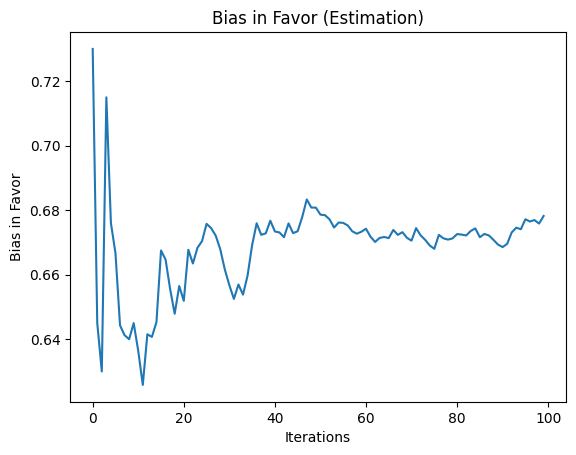

In [35]:
# Parameters for the test
n_sample = 10
delta = 0.5
n_iter = 100        # Adjusted number of theta_0 samples
sigma = 1
prior_mu = 0
prior_sigma = 1
n_marginal = 500   # Adjusted number of samples to estimate p(x)
n_datasets = 100    # Adjusted number of datasets per theta

# Run the function with the adjusted parameters
bias_in_favor = ss_estimation_bias_in_favor(
    n_sample=n_sample,
    delta=delta,
    n_iter=n_iter,
    sigma=sigma,
    prior_mu=prior_mu,
    prior_sigma=prior_sigma,
    n_marginal=n_marginal,
    n_datasets=n_datasets,
    cumulative=True
)
plt.plot(bias_in_favor)
plt.title("Bias in Favor (Estimation)")
plt.xlabel("Iterations")
plt.ylabel("Bias in Favor")
print(f"Bias in Favor (Estimation): {bias_in_favor[-1]}")